<a href="https://colab.research.google.com/github/Mihirirj/Audio_PRE-FE/blob/main/Voice_Emo_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import pickle
import timeit
from tqdm import tqdm

# Audio Processing
import librosa
import librosa.display

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn for Preprocessing and Metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Keras / TensorFlow for Model Building
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense,
    LSTM, Reshape
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


try:
    from google.colab import drive
    print("Running in Google Colab. Installing dependencies.")
    !apt-get update -qq && apt-get install -y libsndfile1 -qq
except ImportError:
    print("Not running in Google Colab. Assuming dependencies are installed.")


print("Libraries imported and system ready.")

Running in Google Colab. Installing dependencies.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Libraries imported and system ready.


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    CREMA_D_PATH = "/content/drive/MyDrive/AudioWAV/"
except ImportError:
    print("Not in Colab. Set your local path for CREMA_D_PATH.")

    CREMA_D_PATH = "./AudioWAV/"

if not os.path.exists(CREMA_D_PATH):
    print(f"ERROR: The path '{CREMA_D_PATH}' does not exist.")
    print("Please make sure you have the 'AudioWAV' folder and the path is correct.")
else:
    print("Dataset path confirmed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset path confirmed.


In [8]:
crema_directory_list = os.listdir(CREMA_D_PATH)

file_emotion = []
file_path = []

for file in crema_directory_list:

    if file.endswith('.wav'):
        file_path.append(os.path.join(CREMA_D_PATH, file))
        part = file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)

print("CREMA-D DataFrame created successfully.")
print("Emotion Counts:")
print(data_path['Emotions'].value_counts())

CREMA-D DataFrame created successfully.
Emotion Counts:
Emotions
fear       1271
disgust    1271
sad        1271
happy      1271
angry      1271
neutral    1087
Name: count, dtype: int64


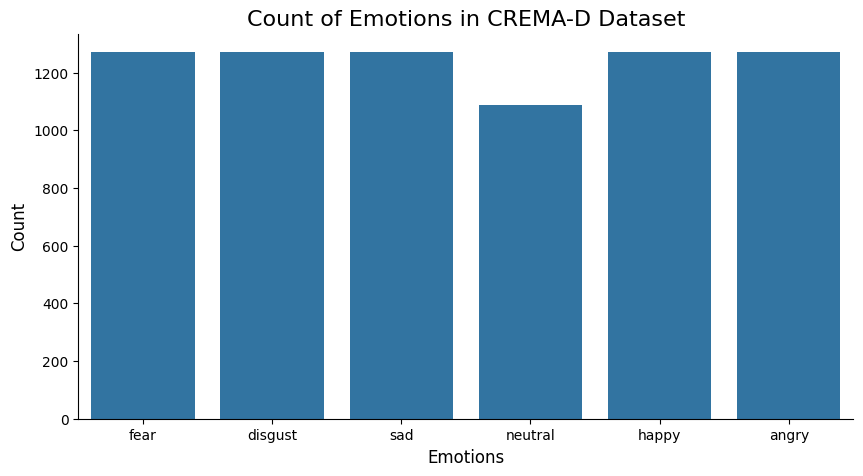

In [9]:
plt.figure(figsize=(10, 5))
plt.title('Count of Emotions in CREMA-D Dataset', size=16)
sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [10]:

def noise(data):

    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):

    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)


def extract_features_sequential(data, sr=22050, n_mfcc=40):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)

    return mfccs.T

def get_features_with_augmentation_sequential(path):


    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    #  Original Features
    res1 = extract_features_sequential(data, sr)
    #  Noise-Augmented Features
    noise_data = noise(data)
    res2 = extract_features_sequential(noise_data, sr)
    # Pitch-Augmented Features
    pitch_data = pitch(data, sr)
    res3 = extract_features_sequential(pitch_data, sr)
    #  Stretch-Augmented Features
    stretch_data = stretch(data)
    res4 = extract_features_sequential(stretch_data, sr)

    return [res1, res2, res3, res4]

print("Functions for feature extraction and augmentation are defined.")

Functions for feature extraction and augmentation are defined.


In [11]:
start_time = timeit.default_timer()
X_seq, Y_seq = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions), total=len(data_path)):
    try:

        feature_list = get_features_with_augmentation_sequential(path)
        for features in feature_list:
            X_seq.append(features)

            Y_seq.append(emotion)
    except Exception as e:
        print(f"Error processing {path}: {e}")


max_len = max([len(x) for x in X_seq])
print(f"\nMaximum sequence length found: {max_len}")

X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', dtype='float32')

stop_time = timeit.default_timer()
print(f'Feature extraction and padding completed in: {stop_time - start_time:.2f}s')


np.save('X_padded_features.npy', X_padded)
np.save('Y_labels.npy', np.array(Y_seq))
with open('max_len.txt', 'w') as f:
    f.write(str(max_len))

print("Sequential features and labels saved to '.npy' files.")
print("Max sequence length saved to 'max_len.txt'")

100%|██████████| 7442/7442 [54:26<00:00,  2.28it/s]



Maximum sequence length found: 135
Feature extraction and padding completed in: 3267.34s
Sequential features and labels saved to '.npy' files.
Max sequence length saved to 'max_len.txt'


In [12]:


X = np.load('X_padded_features.npy')
Y = np.load('Y_labels.npy')


encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()


x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)

scaler = StandardScaler()
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_train_scaled_2d = scaler.fit_transform(x_train_2d)
x_train = x_train_scaled_2d.reshape(x_train.shape)

x_test_2d = x_test.reshape(x_test.shape[0], -1)
x_test_scaled_2d = scaler.transform(x_test_2d)
x_test = x_test_scaled_2d.reshape(x_test.shape)

print(f"Data shapes after splitting and scaling: \nx_train: {x_train.shape}\ny_train: {y_train.shape}\nx_test: {x_test.shape}\ny_test: {y_test.shape}")

Data shapes after splitting and scaling: 
x_train: (23814, 135, 40)
y_train: (23814, 6)
x_test: (5954, 135, 40)
y_test: (5954, 6)


In [13]:

input_shape = (x_train.shape[1], x_train.shape[2])

model = Sequential()

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))


model.add(LSTM(64))
model.add(Dropout(0.3))


model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())


model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 135, 256)       │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 135, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 68, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 68, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 68, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 34, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,686 (1.07 MB)

 Trainable params: 278,662 (1.06 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [14]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

model_checkpoint = ModelCheckpoint('best_cnn_lstm_model.keras', monitor='val_accuracy', save_best_only=True)


history = model.fit(
    x_train, y_train,
    epochs=100, # EarlyStopping will likely stop it before 100 epochs
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, lr_reduction, model_checkpoint]
)

print("Model training complete.")

Epoch 1/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 127s 319ms/step - accuracy: 0.2684 - loss: 1.8031 - val_accuracy: 0.4375 - val_loss: 1.4275 - learning_rate: 0.0010
Epoch 2/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 115s 309ms/step - accuracy: 0.4228 - loss: 1.4213 - val_accuracy: 0.4923 - val_loss: 1.2772 - learning_rate: 0.0010
Epoch 3/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 144s 314ms/step - accuracy: 0.5090 - loss: 1.2600 - val_accuracy: 0.5114 - val_loss: 1.2704 - learning_rate: 0.0010
Epoch 4/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 116s 311ms/step - accuracy: 0.5630 - loss: 1.1484 - val_accuracy: 0.5897 - val_loss: 1.0623 - learning_rate: 0.0010
Epoch 5/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 111s 296ms/step - accuracy: 0.6040 - loss: 1.0636 - val_accuracy: 0.6224 - val_loss: 0.9936 - learning_rate: 0.0010
Epoch 6/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 296ms/step - accuracy: 0.6389 - loss: 0.9705 - val_accuracy: 0.6550 - val_loss: 0.9226 - learning_rate: 0.0010
Epoch 7/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 109s 293ms/step -

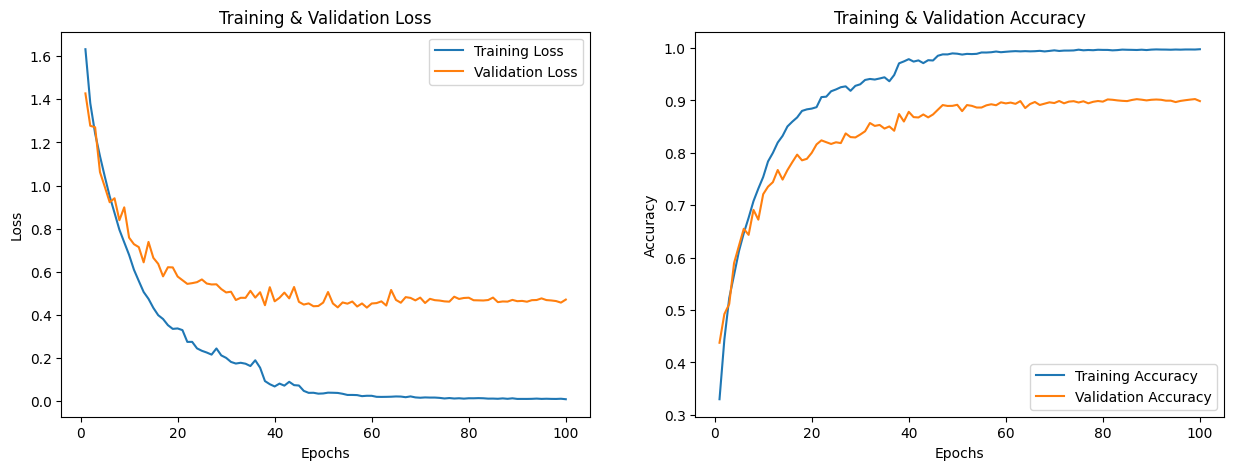


Final Model Evaluation on Test Data:
Test Accuracy: 90.26%
Test Loss: 0.4567
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.96      0.92      0.94      1011
     disgust       0.90      0.89      0.89      1035
        fear       0.89      0.87      0.88      1016
       happy       0.93      0.89      0.91      1015
     neutral       0.88      0.92      0.90       837
         sad       0.86      0.93      0.89      1040

    accuracy                           0.90      5954
   macro avg       0.90      0.90      0.90      5954
weighted avg       0.90      0.90      0.90      5954



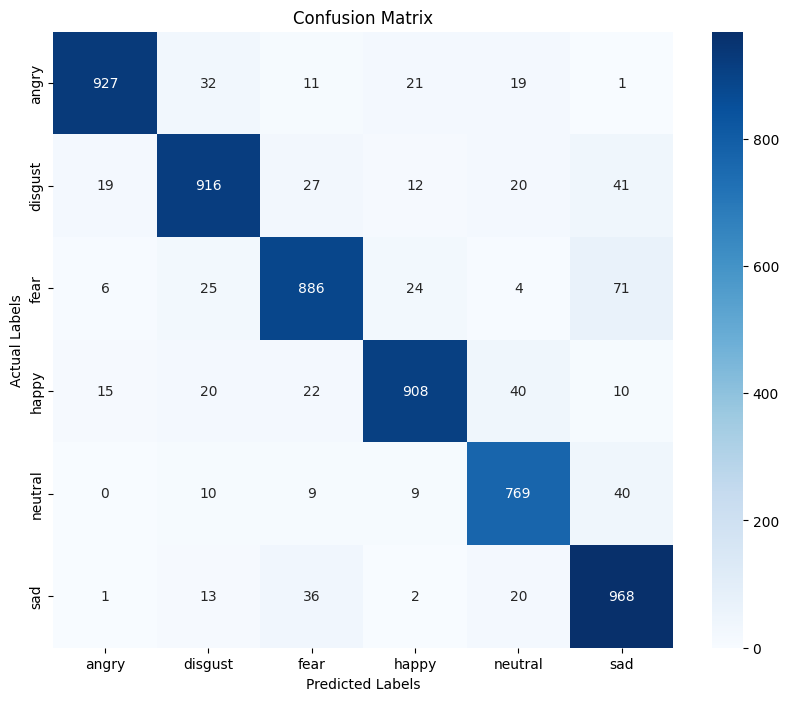


 Example Predictions with Emotional Valence 
Actual: angry      | Predicted: angry      | Valence: Negative
Actual: angry      | Predicted: angry      | Valence: Negative
Actual: sad        | Predicted: sad        | Valence: Negative
Actual: disgust    | Predicted: disgust    | Valence: Negative
Actual: fear       | Predicted: fear       | Valence: Negative
Actual: neutral    | Predicted: neutral    | Valence: Neutral
Actual: happy      | Predicted: happy      | Valence: Positive
Actual: happy      | Predicted: happy      | Valence: Positive
Actual: disgust    | Predicted: fear       | Valence: Negative
Actual: sad        | Predicted: sad        | Valence: Negative


In [15]:
# Plot training history to check for overfitting
epochs = range(1, len(history.history['accuracy']) + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

# Final evaluation on the test data
print("\nFinal Model Evaluation on Test Data:")

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


y_pred = model.predict(x_test)
y_pred_labels = encoder.inverse_transform(y_pred)
y_test_labels = encoder.inverse_transform(y_test)
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=encoder.categories_[0]))

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

def get_valence(emotion):
    emotion = emotion.lower()
    if emotion == 'happy':
        return 'Positive'
    elif emotion in ['sad', 'angry', 'fear', 'disgust']:
        return 'Negative'
    else:
        return 'Neutral'


print("\n Example Predictions with Emotional Valence ")
for i in range(10):
    actual_emotion = y_test_labels[i][0]
    predicted_emotion = y_pred_labels[i][0]
    valence = get_valence(predicted_emotion)
    print(f"Actual: {actual_emotion:<10} | Predicted: {predicted_emotion:<10} | Valence: {valence}")

In [16]:
model_json = model.to_json()
with open("cnn_lstm_model.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved to cnn_lstm_model.json")
print("Best model weights saved to best_cnn_lstm_model.keras")


with open('scaler_seq.pickle', 'wb') as f:
    pickle.dump(scaler, f)
with open('encoder_seq.pickle', 'wb') as f:
    pickle.dump(encoder, f)
print("Scaler saved to scaler_seq.pickle")
print("Encoder saved to encoder_seq.pickle")

Model architecture saved to cnn_lstm_model.json
Best model weights saved to best_cnn_lstm_model.keras
Scaler saved to scaler_seq.pickle
Encoder saved to encoder_seq.pickle


In [17]:

def predict_emotion_and_valence(audio_path):

    with open('cnn_lstm_model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("best_cnn_lstm_model.keras")

    with open('scaler_seq.pickle', 'rb') as f:
        scaler = pickle.load(f)
    with open('encoder_seq.pickle', 'rb') as f:
        encoder = pickle.load(f)
    with open('max_len.txt', 'r') as f:
        max_len = int(f.read())


    data, sr = librosa.load(audio_path, duration=2.5, offset=0.6)
    features = extract_features_sequential(data, sr, n_mfcc=40)
    padded_features = pad_sequences([features], maxlen=max_len, padding='post', dtype='float32')
    padded_features_2d = padded_features.reshape(1, -1)
    scaled_features_2d = scaler.transform(padded_features_2d)
    final_features = scaled_features_2d.reshape(padded_features.shape)


    prediction = loaded_model.predict(final_features, verbose=0)
    predicted_label = encoder.inverse_transform(prediction)[0][0]
    predicted_valence = get_valence(predicted_label)

    return predicted_label, predicted_valence


try:
    # Select a random file from the dataset to test the prediction function
    test_file_path = data_path.Path.sample(1).iloc[0]
    predicted_emotion, predicted_valence = predict_emotion_and_valence(test_file_path)

    print(f"\n--- Prediction Test ---")
    print(f"File Path: {test_file_path}")
    print(f"Predicted Emotion: {predicted_emotion.upper()}")
    print(f"Predicted Valence: {predicted_valence.upper()}")
except Exception as e:
    print(f"\nCould not run prediction example. Error: {e}")


--- Prediction Test ---
File Path: /content/drive/MyDrive/AudioWAV/1052_WSI_ANG_XX.wav
Predicted Emotion: ANGRY
Predicted Valence: NEGATIVE


In [19]:
model.save('my_model.h5')

In [23]:
from google.colab import files

print("Preparing to download 4 essential files...")


files_to_download = [
    'best_cnn_lstm_model.keras',
    'scaler_seq.pickle',
    'encoder_seq.pickle',
    'max_len.txt'
]

Preparing to download 4 essential files...


In [24]:
for filename in files_to_download:
    try:
        print(f"Downloading {filename}...")
        files.download(filename)
        print(f" {filename} download initiated.")
    except Exception as e:
        print(f"Could not find or download {filename}. Error: {e}")
        print("   Please make sure you have run all the previous cells in the notebook.")

print("\nAll downloads have been initiated. Please check your browser's downloads folder.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 best_cnn_lstm_model.keras download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 scaler_seq.pickle download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 encoder_seq.pickle download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 max_len.txt download initiated.

All downloads have been initiated. Please check your browser's downloads folder.
